In [1]:
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Clustering, Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat
# Setting cuda
#if torch.cuda.is_available():

#    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
data = loadmat('cable_exp_20bis.mat')
usol = np.real(data['Expression1'])
usol= usol.reshape((20,200,3))
x_v= usol[:,:,0]
t_v = usol[:,:,1]
u_v = usol[:,:,2]
u_v_full = u_v
u_v =  np.take(u_v,np.arange(0,u_v.shape[0],2),axis=0)

In [3]:
u_v.shape

(10, 200)

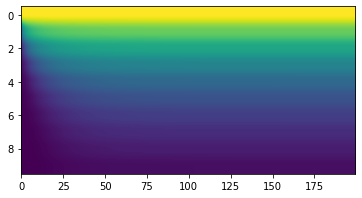

In [4]:
plt.figure(figsize=(6, 6))
plt.imshow(u_v,aspect=10)

In [7]:
noise_level = 0.0

In [8]:
u_v_noise =   u_v + noise_level * np.std(u_v) * np.random.randn(u_v.shape[0],u_v.shape[1])

In [9]:
u_v_noise.shape

(10, 200)

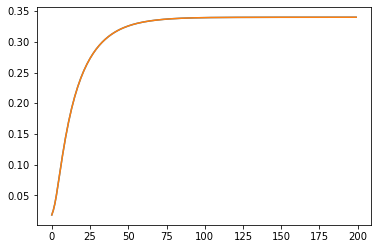

In [10]:
plt.plot(u_v_noise[4,:])
plt.plot(u_v[4,:])

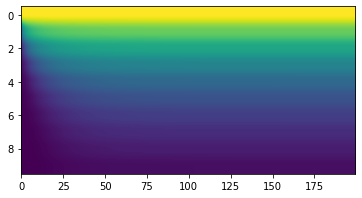

In [11]:
plt.figure(figsize=(6, 6))
plt.imshow(u_v_noise,aspect=10)

In [16]:
output_data = np.take(u_v_noise,np.arange(0,u_v_noise.shape[0],1),axis=0)
output_data.shape

(10, 200)

In [17]:
x = np.linspace(0, 1, output_data.shape[0])
t = np.linspace(0, 1, output_data.shape[1])

In [18]:
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

In [19]:
X = np.transpose((t_grid.flatten(), x_grid.flatten()))
y = np.real(output_data).reshape((output_data.size, 1))
y = y/np.max(y)

In [20]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [21]:
network = NN(2, [30, 30, 30, 30], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [22]:
library = Library1D(poly_order=1, diff_order=2) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [ ]:
estimator = Threshold(0.25) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 

Configuration of the sparsity estimator 

In [18]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [19]:
model = DeepMoD(network, library, estimator, constraint)

In [20]:
# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2.5e-3) 

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [22]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/theory_10', split=0.8, max_iterations=200000, delta=1e-7, patience=200) 

 83350  MSE: 2.41e-04  Reg: 3.54e-06  L1: 6.18e+00 

KeyboardInterrupt: 

In [23]:
print(model.estimator_coeffs())

[array([[ 0.       ],
       [ 0.       ],
       [ 3.238967 ],
       [-2.9150662],
       [ 0.       ],
       [ 0.       ]], dtype=float32)]


In [25]:
sol = model(torch.tensor(X, dtype=torch.float32))[0].reshape(output_data.shape).detach().numpy()

In [26]:
ux = model(torch.tensor(X, dtype=torch.float32))[2][0][:,1].reshape(output_data.shape).detach().numpy()
uxx = model(torch.tensor(X, dtype=torch.float32))[2][0][:,2].reshape(output_data.shape).detach().numpy()

In [27]:
import pysindy as ps

In [28]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

In [29]:
ground_truth = u_v

In [30]:
u_v.shape

(10, 200)

In [31]:
u_v_noise.shape

(10, 200)

In [32]:
sol.shape

(10, 200)

In [33]:
t0 = 100

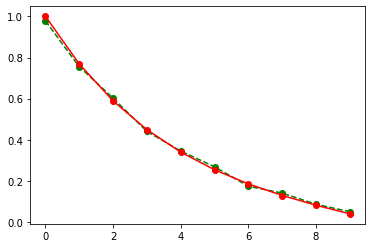

In [34]:
plt.plot(u_v_noise[:,t0],'go--')
plt.plot(u_v[:,t0],'ro')
plt.plot(sol[:,t0]*np.max(output_data),'r')

In [35]:
t0=25

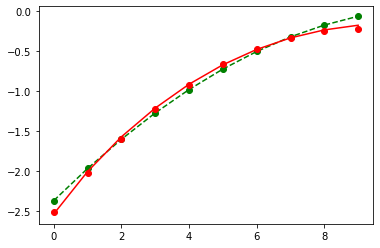

In [36]:
plt.plot(fd_spline(u_v_noise[:,t0],x),'go--')
plt.plot(fd_spline(u_v[:,t0],x),'ro')
plt.plot(ux[:,t0]*np.max(output_data),'r')

In [37]:
t0=10

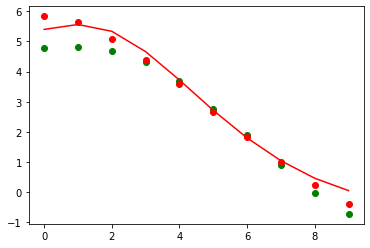

In [39]:
plt.plot(fd_sg(fd_sg(u_v_noise[:,t0],x),x),'go')
plt.plot(fd_sg(fd_sg(u_v[:,t0],x),x),'ro')
plt.plot(uxx[:,t0]*np.max(output_data),'r')

In [40]:
t0=20

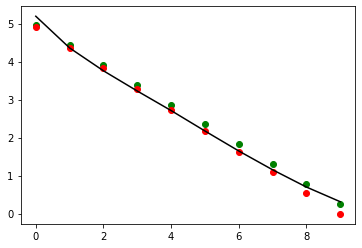

In [44]:
plt.plot(fd_spline(fd_spline(u_v_noise[:,t0],x),x),'go')
plt.plot(fd_spline(fd_spline(u_v[:,t0],x),x),'ro')
plt.plot(uxx[:,t0]*np.max(output_data),'k')

In [122]:
t0=50

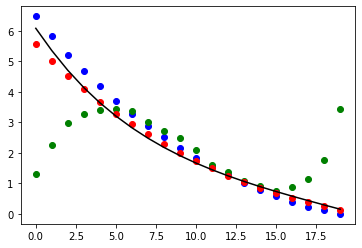

In [123]:
plt.plot(fd_sg(fd_sg(denoised_sol[:,t0],x),x),'bo')
plt.plot(fd_sg(fd_sg(u_v_noise[:,t0],x),x),'go')
plt.plot(fd_sg(fd_sg(u_v[:,t0],x),x),'ro')
plt.plot(uxx[:,t0]*np.max(output_data),'k')

## SVD

In [94]:
u_v_noise.shape

(20, 200)

In [96]:
steps = u_v_noise.shape[0]

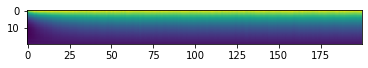

In [106]:
plt.imshow(denoised_sol)

In [97]:
dim_w = 2
denoised_sol = []
for i in np.arange(steps):
    uwn,sigmawn,vwn= np.linalg.svd(u_v_noise[:,i])
    vwn = vwn.T
    denoised_sol.append(uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)))
denoised_sol = np.array(denoised_sol).T

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional